<a href="https://colab.research.google.com/github/Iriswu55555/Predicting-Math-RLA-Achievement-Using-Deep-Learning/blob/main/%E3%80%8CFinal_Project_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("tidyverse")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("keras")
install.packages("reticulate")
install.packages("keras")
install.packages("ISLR2")
install.packages("tensorflow")
install.packages("caret")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘future’, ‘future.apply’, ‘lava’, ‘prodlim’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [ ]:
# load libraries
library(tidyverse)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(keras)
library(tensorflow)
library(reticulate)

# clear environment
rm(list=ls())

Load data from .csv file

In [ ]:
Data <- read.csv('/content/Data_Table_01.csv')

Make some plots

In [ ]:
# scatter plot of longiude and latitude
ggplot(Data,aes(x=lon,y=lat,)) + geom_point()

# scatter plot of longiude and latitude
ggplot(Data[!is.na(Data$locale),],aes(x=lon,y=lat,)) + geom_point()

# scatter plot of longiude and latitude
ggplot(Data[!is.na(Data$cs_mn_avg_ol),],aes(x=lon,y=lat,)) + geom_point()


Load image dataset

In [ ]:
getwd()
dir_list <- list.dirs("",recursive = FALSE) 

[1] "/content"

In [ ]:
unzip("google_maps_satellite_227_227_14_classes.zip")

Warning message in unzip("google_maps_satellite_227_227_14_classes.zip"):
“error 1 in extracting from zip file”


In [ ]:
img_height <- as.integer(180)
img_width <- as.integer(180)
channels <- as.integer(3)
batch_size <- as.integer(128)
num_classes <- as.integer(3)

In [ ]:
maps <- ("google_maps_satellite_227_227_14_classes")
train_data_gen <- image_data_generator(rescale = 1/255, 
  validation_split = .2)
train_images <- flow_images_from_directory(maps,
  train_data_gen,
  subset = 'training',
  class_mode = "categorical",
  shuffle=F,
  seed = 2021)

In [ ]:
train_ds <- image_dataset_from_directory(
    "google_maps_satellite_227_227_14_classes",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=c(img_height,img_width),
    batch_size=batch_size,
)

test_ds <- image_dataset_from_directory(
    "google_maps_satellite_227_227_14_classes",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=c(img_height,img_width),
    batch_size=batch_size,
)

In [ ]:
#Print class names
class_names = train_ds$class_names
print(class_names)

Regular dense network:

In [ ]:
#Build the model
nn_dense <- keras_model_sequential() %>%
  #input layer
  layer_dense(units = 100, input_shape = ncol(train_ds), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(100))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer one
  layer_dense(units = 50, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(50))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer two
  layer_dense(units = 25, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(25))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer three
  layer_dense(units = 10, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(10))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #output layer 
  layer_dense(units = ncol(y_train), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(ncol(y_train)))) %>%
  layer_activation("softmax")

CNN example:

In [ ]:
#Build model
cnn_model <- keras_model_sequential() %>%
  layer_rescaling(1/255, input_shape=c(img_height,img_width,channels)) %>%
  layer_conv_2d(16, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_conv_2d(32, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_conv_2d(64, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_flatten() %>%
  layer_dense(128, activation='relu') %>%
  layer_dense(num_classes)

In [ ]:
#from_logits should be set to true since softmax was not used in the last output layer
#If softmax is used in the output layer then from_logits should be set to false (which is the default)
cnn_model %>% compile(
  loss = loss_mean_squared_error(),
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

In [ ]:
summary(cnn_model)

In [ ]:
epochs <- 3
cnn_history <- cnn_model %>% fit(
  train_ds,
  epochs = epochs,
  validation_data = test_ds,
  verbose=1
)

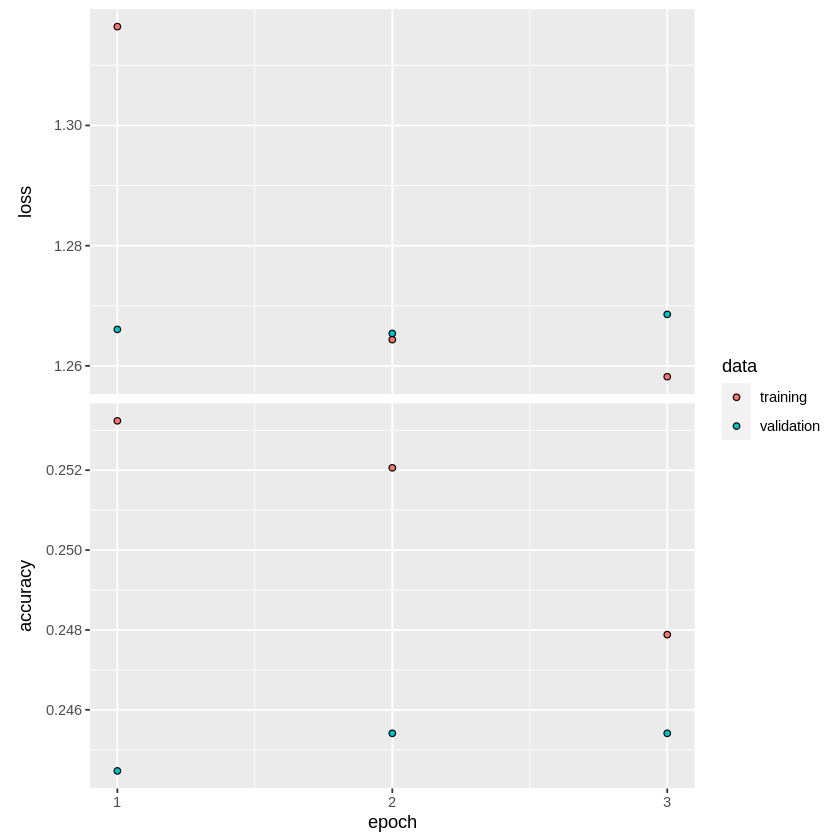

In [ ]:
plot(cnn_history)

In [ ]:
cnn_history

In [ ]:
#Augment data
data_augmentation <- keras_model_sequential() %>%
  layer_random_flip("horizontal", input_shape=c(img_height,img_width,channels)) %>%
  layer_random_rotation(0.1) %>%
  layer_random_zoom(0.1)

In [ ]:
#Build model with data augmentation
cnn_model <- keras_model_sequential() %>%
  data_augmentation %>%
  layer_rescaling(1/255) %>%
  layer_conv_2d(16, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_conv_2d(32, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_conv_2d(64, 3, padding='same', activation='relu') %>%
  layer_max_pooling_2d() %>%
  layer_dropout(0.2) %>%
  layer_flatten() %>%
  layer_dense(128, activation='relu') %>%
  layer_dense(num_classes)

In [ ]:
cnn_model %>% compile(
  loss = loss_mean_squared_error(),
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

In [ ]:
epochs <- 3
cnn_history_2 <- cnn_model %>% fit(
  train_ds,
  epochs = epochs,
  validation_data = test_ds,
  verbose=1
)

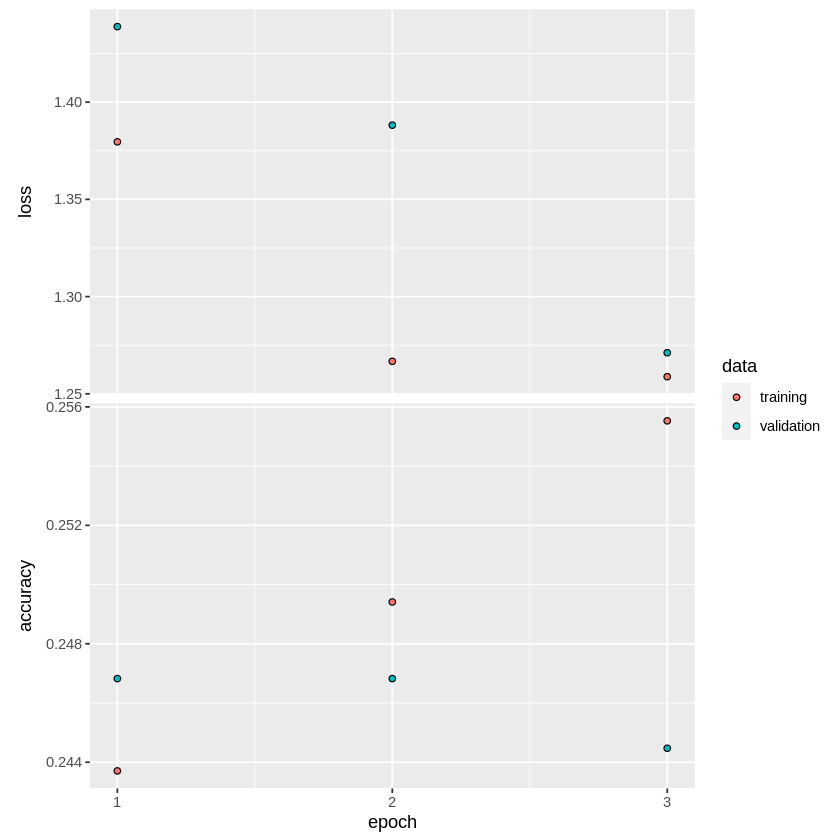

In [ ]:
plot(cnn_history_2)

In [ ]:
# Predict
predictions <- cnn_model %>% predict(test_ds)
predictions[1, ]
which.max(predictions[1, ])

Transfer learning:

In [ ]:
#Load the Xception pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model <- application_xception(weights='imagenet',input_shape=c(img_height,img_width,3),include_top=FALSE)

In [ ]:
#To prevent the base model being retrained
base_model.trainable <- FALSE

In [ ]:
finetune_model <- base_model$output %>% 
  layer_global_average_pooling_2d(trainable = T) %>%  
  layer_dense(64, activation = "relu", trainable = T) %>%  # trainable parameter set to true indicates that the weights for this layer will be updated during training
  layer_dropout(0.4, trainable = T) %>%
  layer_dense(3, activation = "softmax", trainable=T)

model <- keras_model(inputs = base_model$input, outputs = finetune_model)

In [ ]:
#Set the base model layers to be not trainable. i.e do not update weights during training
for (layer in base_model$layers)
  layer$trainable <- FALSE

In [ ]:
#Compile and fit
model %>% compile(
  loss = loss_mean_squared_error(),
  optimizer = optimizer_adam(),
  metrics = c('accuracy')
)

epochs <- 2
model_history <- model %>% fit(
  train_ds,
  epochs = epochs,
  validation_data = test_ds,
  verbose=1
)

In [ ]:
model_history